# Infinite Data Stream

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`
Precompiling project...
  ✓ RxInfer
  1 dependency successfully precompiled in 10 seconds. 238 already precompiled.


In [2]:
using RxInfer

We assume that we don't know the shape of our signal in advance. So we try to fit a simple gaussian random walk with unknown observation noise:

In [3]:
@model function kalman_filter()
    
    # Reactive inputs
    x_t_min_mean = datavar(Float64)
    x_t_min_var  = datavar(Float64)
    τ_shape = datavar(Float64)
    τ_rate  = datavar(Float64)

    τ ~ Gamma(shape = τ_shape, rate = τ_rate)
    
    x_t_min ~ Normal(mean = x_t_min_mean, variance = x_t_min_var)
    x_t     ~ Normal(mean = x_t_min, precision = 1.0)
    
    y = datavar(Float64)
    y ~ Normal(mean = x_t, precision = τ)
    
end

@constraints function filter_constraints()
    q(x_t, τ) = q(x_t)q(τ)
end

filter_constraints (generic function with 1 method)

In [4]:
function start_inference(data_stream)
    
    model, _ = create_model(kalman_filter(), filter_constraints(), nothing, nothing)
    
    x_t_min_prior = NormalMeanVariance(0.0, 1e7)
    τ_prior       = GammaShapeRate(1.0, 1.0)
    
    x_t_stream = Subject(Marginal)
    τ_stream   = Subject(Marginal)
    
    main = combineLatest((
        getmarginal(model[:x_t], IncludeAll()), 
        getmarginal(model[:τ], IncludeAll()), 
        data_stream
    ), PushNew())
    
    save_scheduler = PendingScheduler()
    
    vmp_iterations = 5
    
    main_cb = (d) -> begin
                
        x_t_next_prior = d[1]
        τ_next_prior   = d[2]
        observation    = d[3]
        
        for i in 1:vmp_iterations
            ReactiveMP.update!(model[:x_t_min_mean], mean(x_t_next_prior))
            ReactiveMP.update!(model[:x_t_min_var], var(x_t_next_prior))
            ReactiveMP.update!(model[:τ_shape], shape(τ_next_prior))
            ReactiveMP.update!(model[:τ_rate], rate(τ_next_prior))
            ReactiveMP.update!(model[:y], observation)
        end
            
        ReactiveMP.release!(save_scheduler)
    end
    
    subscription = subscribe!(main, main_cb)
    
    save = combineLatest((
        getmarginal(model[:x_t], IncludeAll()), 
        getmarginal(model[:τ], IncludeAll()),
    ), PushEach()) |> schedule_on(save_scheduler)
    
    save_cb = (p) -> begin
        ReactiveMP.next!(x_t_stream, p[1])
        ReactiveMP.next!(τ_stream, p[2])
    end
    
    save_subscribtion = subscribe!(save, save_cb)
    
    setmarginal!(model[:x_t], x_t_min_prior)
    setmarginal!(model[:τ], τ_prior)
    
    return x_t_stream, τ_stream, () -> begin
        unsubscribe!(save_subscribtion)
        unsubscribe!(subscription)
    end
end

start_inference (generic function with 1 method)

In [5]:
mutable struct DataGenerationProcess
    previous :: Float64
    process_noise :: Float64
    observation_noise :: Float64
    history :: Vector{Float64}
    observations :: Vector{Float64}
end

function getnext!(process::DataGenerationProcess)
    process.previous = process.previous + 1.0
    next = 10sin(0.1 * process.previous)
    observation = next + rand(Normal(0.0, process.observation_noise))
    push!(process.history, next)
    push!(process.observations, observation)
    return observation
end

function gethistory(process::DataGenerationProcess)
    return process.history
end

function getobservations(process::DataGenerationProcess)
    return process.observations
end

getobservations (generic function with 1 method)

In [6]:
using Plots

In [74]:
# We force stop after n data points
n = 250

250

In [62]:
plot_callback = (posteriors) -> begin
    IJulia.clear_output(true)

    p = plot(mean.(posteriors), ribbon = var.(posteriors), label = "Estimation")
    p = plot!(gethistory(process), label = "Real states")    
    p = scatter!(getobservations(process), ms = 2, label = "Observations")
    p = plot(p, size = (1000, 400), legend = :bottomright)
        
    display(p)
end

#63 (generic function with 1 method)

In [75]:
process = DataGenerationProcess(0.0, 1.0, 10.0, Float64[], Float64[])
# stream = timer(100, 100) |> map_to(process) |> map(Float64, getnext!) |> take(n)
stream = from(1:n) |> map_to(process) |> map(Float64, getnext!)

keystream = stream |> map(NamedTuple{(:y,), Tuple{Float64}}, (d) -> (y = d, ))

ProxyObservable(NamedTuple{(:y,), Tuple{Float64}}, MapProxy(Float64))

In [64]:
redirect = (
    x_t = (q) -> (x_t_min_mean = mean(q), x_t_min_var = var(q)),
    τ = (q) -> (τ_shape = shape(q), τ_rate = rate(q))
)

(x_t = var"#67#69"(), τ = var"#68#70"())

  0.007501 seconds (60.09 k allocations: 2.465 MiB)


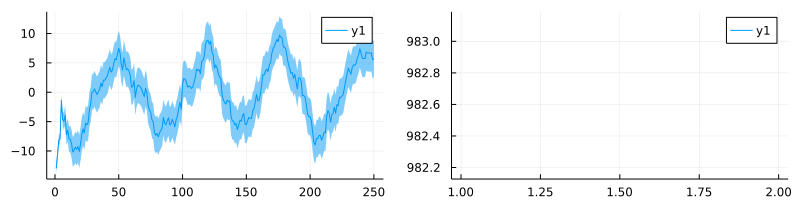

In [118]:
@time result = rxinference(
    model = kalman_filter(),
    constraints = filter_constraints(),
    data = keystream,
    returnvars = KeepEach(),
    initmarginals = (
        x_t = NormalMeanVariance(0.0, 1e3),
        τ = GammaShapeRate(1.0, 1.0)
    ),
    iterations = 1,
    free_energy = true,
    redirect = redirect
);

qxt = getvalues(result.posteriors[:x_t])

p1 = plot(mean.(qxt), ribbon = std.(qxt))
p2 = plot(getvalues(result.free_energy))

plot(p1, p2, size = (800, 200))

In [102]:
result.posteriors[:x_t];

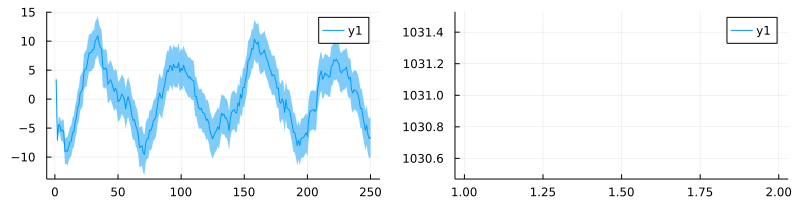

In [87]:
mean.(getvalues(result.posteriors[:τ]))

250-element Vector{Float64}:
 1.0003173580835838
 0.19701519878329032
 0.035408581947486646
 0.020485351406965575
 0.010140125415277963
 0.011360060335126083
 0.006013161005342414
 0.006437754806389032
 0.006713795233771525
 0.00728204560581098
 0.0071447694383358455
 0.006083807583666717
 0.005754431230660919
 ⋮
 0.007214291747136445
 0.007218980281145889
 0.0072454736162123135
 0.007256745778553635
 0.007281292171441562
 0.007306608085436846
 0.007311509584599478
 0.007326065113059652
 0.007341397314902459
 0.007368386651932338
 0.007394560071570938
 0.007421571568961751

In [280]:
s = Subject(Int)

Subject(Int64, AsapScheduler)

In [165]:
subscribe!(zipped(s, from(1:10)), logger());

In [176]:
next!(s, 0)